## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import pickle

2024-11-19 06:26:23.730260: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 06:26:23.731836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 06:26:23.765404: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 06:26:23.766348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 06:26:24.405503: W tensorflow/compiler/tf2t

## Download dataset and pre processing

In [2]:
# CIFAR-10 dosyasının olduğu yolu belirtin
cifar10_dir = "data/cifar-10-batches-py"  # Dosyayı çıkardıktan sonra buraya kaydedin

def load_batch(filepath):
    """CIFAR-10'daki tek bir batch dosyasını yükler."""
    with open(filepath, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']
        return data, labels

def load_cifar10(data_dir):
    """CIFAR-10 veri setini yükler ve eğitim/test ayrımını yapar."""
    # Eğitim verisini yükleyelim
    x_train = []
    y_train = []
    for i in range(1, 6):  # 5 batch dosyası
        data_path = os.path.join(data_dir, f"data_batch_{i}")
        data, labels = load_batch(data_path)
        x_train.append(data)
        y_train += labels

    x_train = np.concatenate(x_train)  # Tüm batch'leri birleştiriyoruz
    y_train = np.array(y_train)

    # Test verisini yükleyelim
    test_path = os.path.join(data_dir, "test_batch")
    x_test, y_test = load_batch(test_path)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Şekilleri düzenleyelim
    x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # (N, 3, 32, 32) -> (N, 32, 32, 3)
    x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)    # (N, 3, 32, 32) -> (N, 32, 32, 3)

    return (x_train, y_train), (x_test, y_test)

# CIFAR-10 veri setini yükleme
(x_train, y_train), (x_test, y_test) = load_cifar10(cifar10_dir)

# Veriyi normalize ediyoruz
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Etiketleri kategorik forma çevirme
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Verinin boyutlarını kontrol edelim
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 10)


In [3]:
# CIFAR-10 veri setini yüklüyoruz
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

 CIFAR-10 veri kümesindeki 10 sınıfı sınıflandırmak için CNN mimarisi kullanılmıştır. CIFAR-10 veri kümesi, 32x32 çözünürlüğünde ve 3 kanallı (RGB) renklere sahip 10 sınıf içerir.

In [ ]:
# CIFAR-10 sınıf isimleri
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Görselleştirecek örnek sayısı
num_examples = 12

plt.figure(figsize=(10, 5))
for i in range(num_examples):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Veri tipini float32'ye çevir ve normalizasyon yapıyoruz
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Sınıf etiketlerini one-hot encoding yapıyoruz
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

CNN Mimarisi
- 1.Katman: 32 filtre kullanarak 3x3 boyutunda bir kernel uygular. 'relu' aktivasyon fonksiyonu kullanılır.
- 2.Katman: İlk katmanın çıkışını girdi olarak alır daha derin özellikler çıkarır.
- MaxPooling: 2x2 havuzlama, boyut azaltma.
- Dropout: Eğitim sırasında %25 oranında nöronları rastgele devre dışı bırakır (overfitting önleme).
- 3.Katman: 64 filtre kullanarak daha fazla özellik çıkarır.
- 4.Katman: Ardışık Conv2D katmanları ile özellik çıkarımı güçlendirilir.
- MaxPooling: 2x2 havuzlama, boyut azaltma.
- Dropout: Yine %25 oranında nöronları devre dışı bırakarak aşırı öğrenme ihtimalini azaltır.
- Flatten: Çıkış verisini tek bir vektör haline getirir. Bu vektör, tam bağlantılı (Dense) katman için giriş olur.
- Dense: 512 nöronlu fully connected katman.
- Dropout: %50 oranında nöronları rastgele devre dışı bırakır. Modelin genelleme yeteneğini artırır.
- Çıkış Katmanı: 10 sınıflı, 'softmax' ile her bir sınıfa ait olasılık tahmini.

In [5]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [6]:
# 5 farklı başlangıç noktası oluşturuyoruz
initial_weights = []
for _ in range(5):
    model = create_model()
    initial_weights.append(model.get_weights())

2024-11-19 06:26:34.555387: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 64)        36928     
                                                      

In [8]:
# Optimizasyon algoritmaları ve parametreleri tanımlıyoruz
optimizer_configs = {
    'SGD': {'class': SGD, 'params': {'learning_rate': 0.01}},
    'SGD_momentum': {'class': SGD, 'params': {'learning_rate': 0.01, 'momentum': 0.9}},
    'Adam': {'class': Adam, 'params': {'learning_rate': 0.001}}
}

### Optimizations Algorithms

In [9]:
# Eğitim parametrelerini tanımlıyoruz
batch_size = 32
epochs = 5

# Sonuçları saklamak için listeleri tutuyoruz
trajectories = {}
history_records = {}
time_records = {}

for opt_name, opt_config in optimizer_configs.items():
    print(f"\nOptimizasyon Algoritması: {opt_name}")
    trajectories[opt_name] = []
    history_records[opt_name] = []
    time_records[opt_name] = []
    for idx, w0 in enumerate(initial_weights):
        print(f"\nBaşlangıç Noktası: {idx+1}")
        # Modeli başlangıç ağırlıklarıyla yeniden oluştur
        model = create_model()
        model.set_weights(w0)

        # Her model için optimizer'ı yeniden oluştur #aynı optimizer'ı kullanırken hata verdiği için eklendi
        optimizer_class = opt_config['class']
        optimizer_params = opt_config['params']
        optimizer = optimizer_class(**optimizer_params)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Ağırlık yörüngelerini saklamak için liste tutuyoruz
        weight_trajectory = []
        epoch_times = []
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        # **Başlangıç ağırlıklarını kaydet**
        initial_weights_vector = np.concatenate([w.flatten() for w in model.get_weights()])
        weight_trajectory.append(initial_weights_vector)

        for epoch in range(epochs):
            print(f"\n=== {opt_name} | Başlangıç Noktası {idx+1} | Epoch {epoch+1}/{epochs} ===")
            start_time = time.time()
            # Eğitimi bir epoch için gerçekleştir (her bir epoch sonunda ağırlıkları kaydedip eklemek için)
            model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_data=(x_test, y_test), verbose=1)
            end_time = time.time()
            # Epoch süresini kaydet
            epoch_times.append(end_time - start_time)
            # Ağırlıkları kaydet
            weights = np.concatenate([w.flatten() for w in model.get_weights()])
            weight_trajectory.append(weights)
            # Kayıp ve doğruluğu kaydet
            loss, acc = model.evaluate(x_train, y_train, verbose=0)
            val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)
            history['loss'].append(loss)
            history['accuracy'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

        # Sonuçları sakla
        trajectories[opt_name].append(np.array(weight_trajectory))
        history_records[opt_name].append(history)
        time_records[opt_name].append(np.array(epoch_times))



Optimizasyon Algoritması: SGD

Başlangıç Noktası: 1

=== SGD | Başlangıç Noktası 1 | Epoch 1/5 ===
1563/1563 [==============================] - 17s 11ms/step - loss: 2.0589 - accuracy: 0.2301 - val_loss: 2.1985 - val_accuracy: 0.2236

=== SGD | Başlangıç Noktası 1 | Epoch 2/5 ===
1563/1563 [==============================] - 17s 11ms/step - loss: 1.7588 - accuracy: 0.3543 - val_loss: 1.5942 - val_accuracy: 0.4170

=== SGD | Başlangıç Noktası 1 | Epoch 3/5 ===
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6221 - accuracy: 0.4040 - val_loss: 1.4592 - val_accuracy: 0.4662

=== SGD | Başlangıç Noktası 1 | Epoch 4/5 ===
1563/1563 [==============================] - 16s 10ms/step - loss: 1.4972 - accuracy: 0.4543 - val_loss: 1.4199 - val_accuracy: 0.4877

=== SGD | Başlangıç Noktası 1 | Epoch 5/5 ===
1563/1563 [==============================] - 15s 10ms/step - loss: 1.4007 - accuracy: 0.4920 - val_loss: 1.2756 - val_accuracy: 0.5427

Başlangıç Noktası: 2

=== SGD | Başl

**learning_rate**: Öğrenme oranı, optimizasyon sürecinin adım büyüklüğünü belirler.learning_rate='auto' olarak ayarlandığında, t-SNE veri setinin
boyutuna göre uygun bir öğrenme oranı seçer.  

In [10]:
# TEST ET
# 7. Yörüngelerin t-SNE ile 2 Boyuta İndirgenmesi

# Tüm yörüngeleri birleştir
all_trajectories = []
labels = []

for idx in range(len(initial_weights)):
    for opt_name in optimizer_configs.keys():
        traj = trajectories[opt_name][idx]
        all_trajectories.append(traj)
        labels.append(opt_name)

# Yörüngeleri birleştir ve şekillendir
all_points = np.concatenate(all_trajectories, axis=0)

# t-SNE uygulaması
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000, learning_rate='auto', init='pca', verbose=1)
tsne_results = tsne.fit_transform(all_points)

# Her yörüngenin başlangıç ve bitiş indekslerini bul
trajectory_lengths = [len(traj) for traj in all_trajectories]

[t-SNE] Computing 89 nearest neighbors...
[t-SNE] Indexed 90 samples in 0.052s...
[t-SNE] Computed neighbors for 90 samples in 1.988s...
[t-SNE] Computed conditional probabilities for sample 90 / 90
[t-SNE] Mean sigma: 34.654213
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.877270
[t-SNE] KL divergence after 750 iterations: 0.050349


/opt/app-root/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


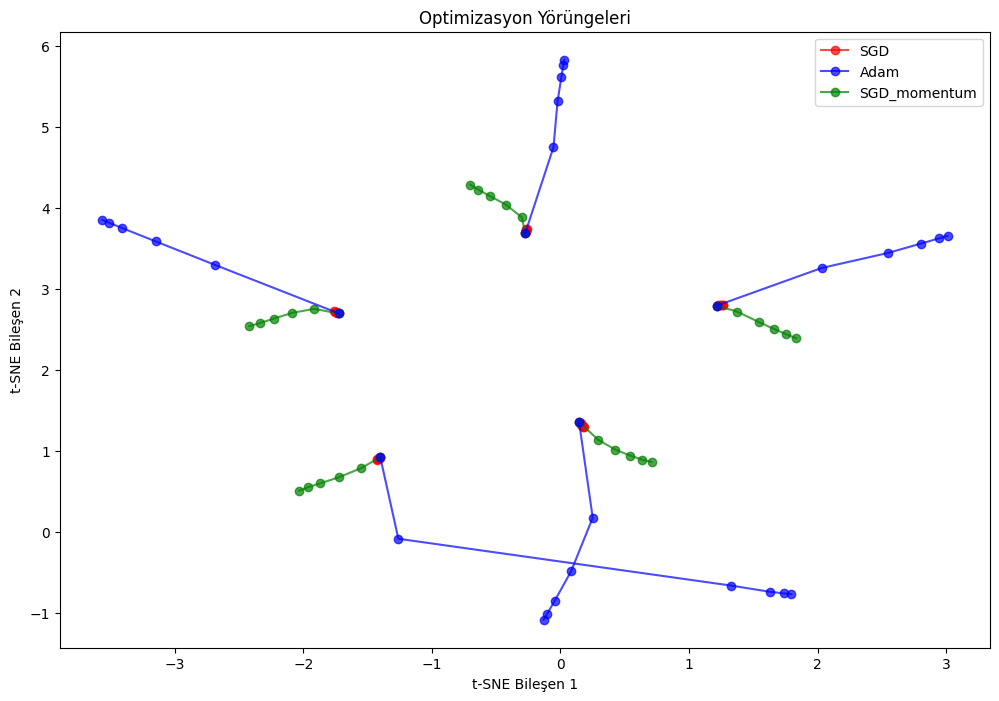

In [11]:
# TEST ET
# 8. Yörüngelerin Görselleştirilmesi

# Renkleri belirle
colors = {'SGD': 'r', 'SGD_momentum': 'g', 'Adam': 'b'}

plt.figure(figsize=(12, 8))

start_idx = 0
for i, (opt_name, traj_len) in enumerate(zip(labels, trajectory_lengths)):
    end_idx = start_idx + traj_len
    x = tsne_results[start_idx:end_idx, 0]
    y = tsne_results[start_idx:end_idx, 1]
    # Her yörüngeyi çiz
    plt.plot(x, y, color=colors[opt_name],marker='o', label=opt_name if i % 5 == 0 else "", alpha=0.7)
    start_idx = end_idx

# Legend'da sadece algoritmaları göstermek için benzersiz etiketleri alalım
handles, labels_unique = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_unique, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Optimizasyon Yörüngeleri')
plt.xlabel('t-SNE Bileşen 1')
plt.ylabel('t-SNE Bileşen 2')
plt.show()

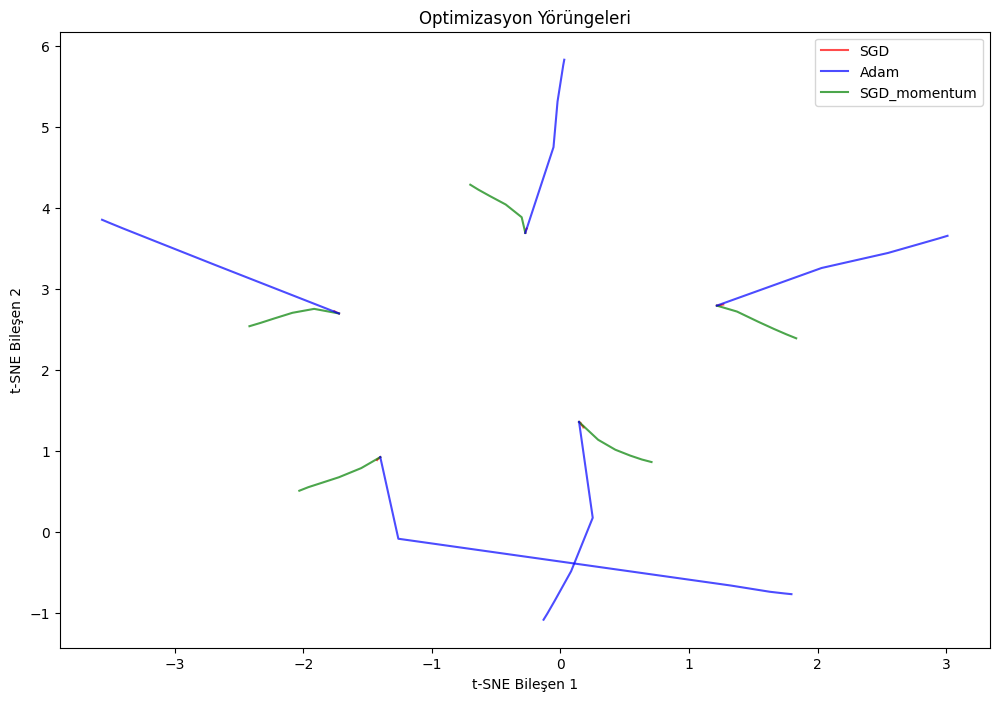

In [12]:
# TEST ET
# 8. Yörüngelerin Görselleştirilmesi

# Renkleri belirle
colors = {'SGD': 'r', 'SGD_momentum': 'g', 'Adam': 'b'}

plt.figure(figsize=(12, 8))

start_idx = 0
for i, (opt_name, traj_len) in enumerate(zip(labels, trajectory_lengths)):
    end_idx = start_idx + traj_len
    x = tsne_results[start_idx:end_idx, 0]
    y = tsne_results[start_idx:end_idx, 1]
    # Her yörüngeyi çiz
    plt.plot(x, y, color=colors[opt_name], label=opt_name if i % 5 == 0 else "", alpha=0.7)
    start_idx = end_idx

# Legend'da sadece algoritmaları göstermek için benzersiz etiketleri alalım
handles, labels_unique = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_unique, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Optimizasyon Yörüngeleri')
plt.xlabel('t-SNE Bileşen 1')
plt.ylabel('t-SNE Bileşen 2')
plt.show()

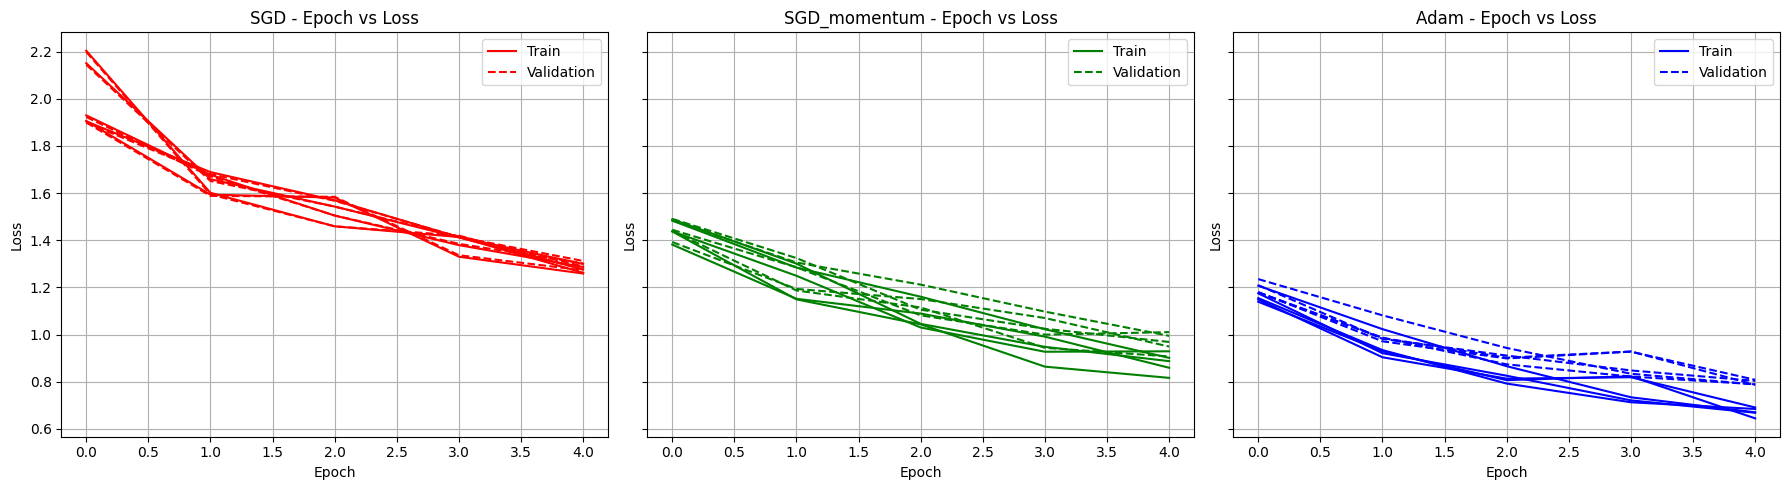

In [13]:
# Epoch vs Loss
# Optimizasyon algoritmalarının isimlerini alıyoruz
optimizer_names = list(optimizer_configs.keys())

# 3 tane alt grafik
num_algorithms = len(optimizer_names)

# Alt grafiklerin boyutlarını ayarlıyoruz
fig, axes = plt.subplots(nrows=1, ncols=num_algorithms, figsize=(6*num_algorithms, 5), sharey=True)

# Eğer tek bir grafik varsa, axes'i liste haline getirelim
if num_algorithms == 1:
    axes = [axes]

for idx, opt_name in enumerate(optimizer_names):
    ax = axes[idx]
    # Her algoritma için tüm başlangıç noktalarındaki eğitim geçmişini çizeceğiz
    for history in history_records[opt_name]:
        # Eğitim kaybı (Train Loss)
        ax.plot(history['loss'], linestyle='-', color=colors[opt_name],
                label='Train' if history == history_records[opt_name][0] else "")
        # Doğrulama kaybı (Validation Loss)
        ax.plot(history['val_loss'], linestyle='--', color=colors[opt_name],
                label='Validation' if history == history_records[opt_name][0] else "")

    ax.set_title(f'{opt_name} - Epoch vs Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


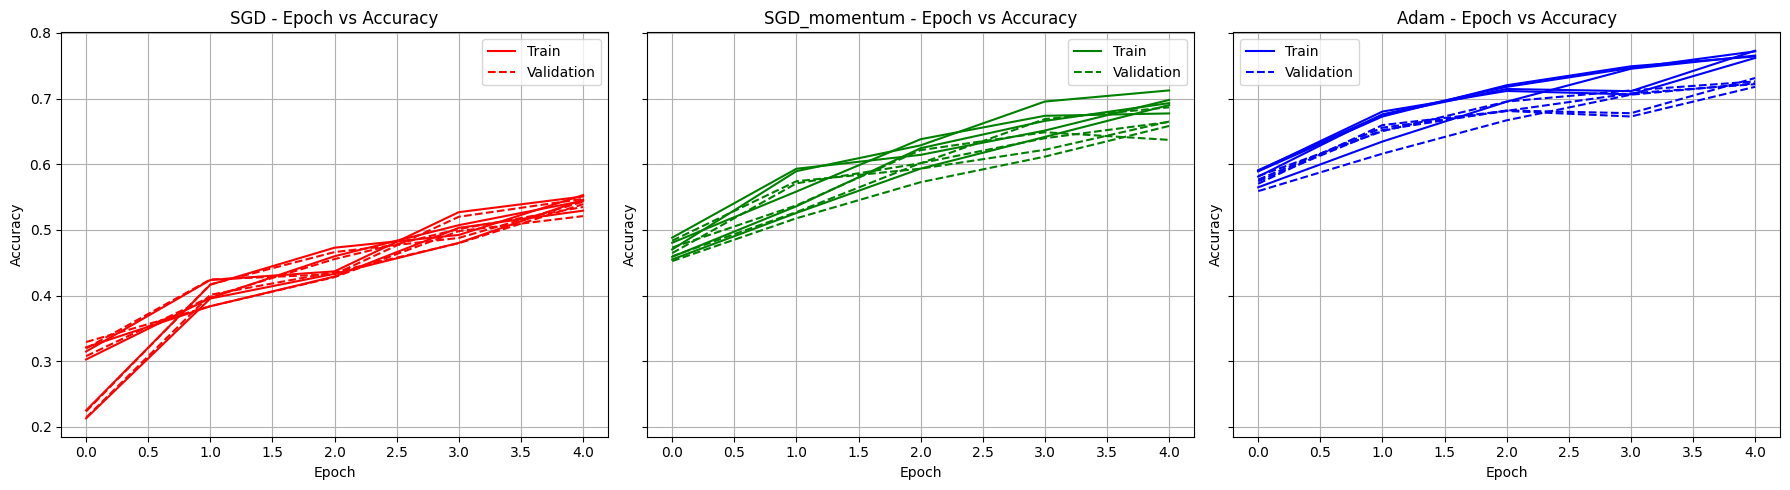

In [14]:
# Epoch vs Accuracy
# Alt grafiklerin boyutlarını ayarlıyoruz
fig, axes = plt.subplots(nrows=1, ncols=num_algorithms, figsize=(6*num_algorithms, 5), sharey=True)

# Eğer tek bir grafik varsa, axes'i liste haline getirelim
if num_algorithms == 1:
    axes = [axes]

for idx, opt_name in enumerate(optimizer_names):
    ax = axes[idx]
    # Her algoritma için tüm başlangıç noktalarındaki eğitim geçmişini çizeceğiz
    for history in history_records[opt_name]:
        # Eğitim doğruluğu (Train Accuracy)
        ax.plot(history['accuracy'], linestyle='-', color=colors[opt_name],
                label='Train' if history == history_records[opt_name][0] else "")
        # Doğrulama doğruluğu (Validation Accuracy)
        ax.plot(history['val_accuracy'], linestyle='--', color=colors[opt_name],
                label='Validation' if history == history_records[opt_name][0] else "")

    ax.set_title(f'{opt_name} - Epoch vs Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


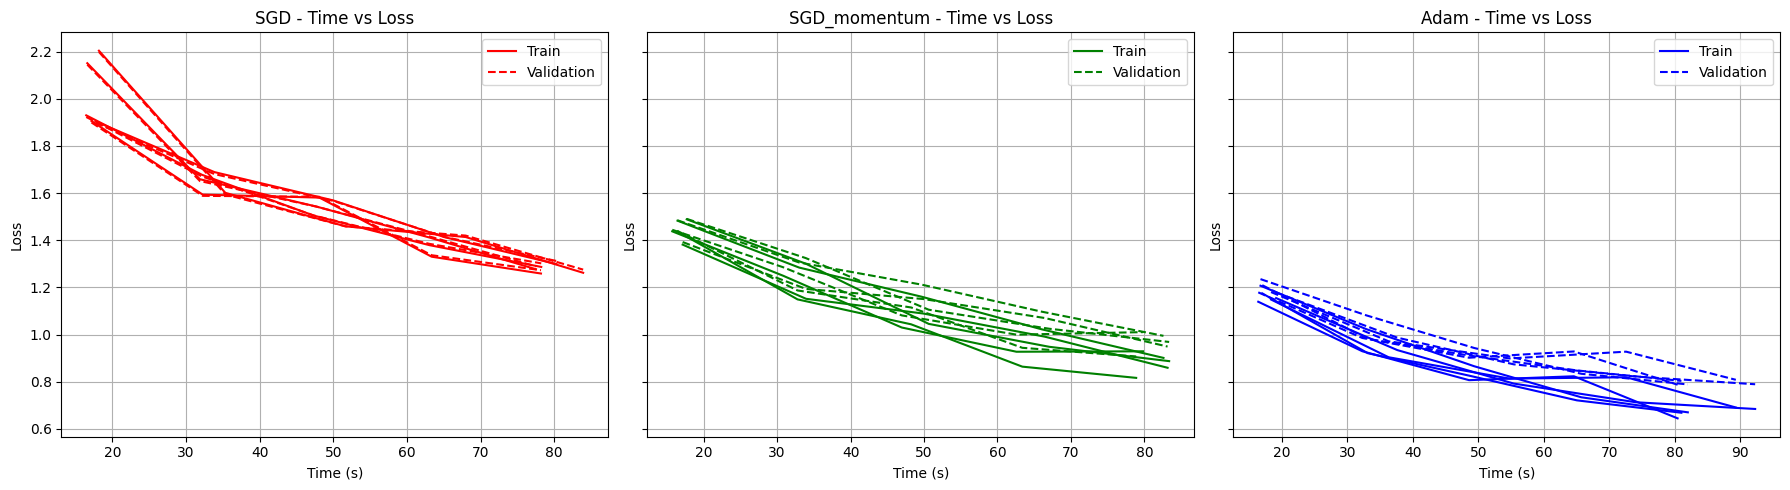

In [15]:
# Time vs Loss
# Alt grafiklerin boyutlarını ayarlıyoruz
fig, axes = plt.subplots(nrows=1, ncols=num_algorithms, figsize=(6*num_algorithms, 5), sharey=True)

# Eğer tek bir grafik varsa, axes'i liste haline getirelim
if num_algorithms == 1:
    axes = [axes]

for idx, opt_name in enumerate(optimizer_names):
    ax = axes[idx]
    # Her algoritma için tüm başlangıç noktalarındaki eğitim geçmişini çizeceğiz
    for idx_hist, (history, times) in enumerate(zip(history_records[opt_name], time_records[opt_name])):
        cumulative_times = np.cumsum(times)
        # Eğitim kaybı (Train Loss)
        ax.plot(cumulative_times, history['loss'], linestyle='-', color=colors[opt_name],
                label='Train' if idx_hist == 0 else "")
        # Doğrulama kaybı (Validation Loss)
        ax.plot(cumulative_times, history['val_loss'], linestyle='--', color=colors[opt_name],
                label='Validation' if idx_hist == 0 else "")

    ax.set_title(f'{opt_name} - Time vs Loss')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


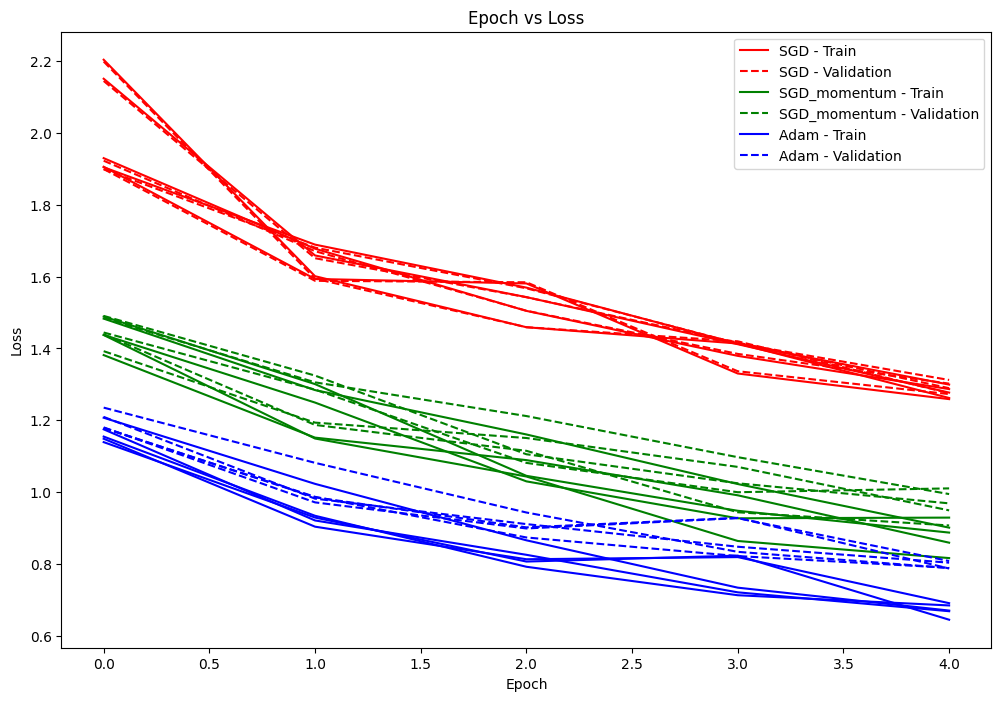

In [16]:
#### Epoch vs Loss Grafiği (Tümü)

plt.figure(figsize=(12, 8))

for opt_name in optimizer_configs.keys():
    for history in history_records[opt_name]:
        # Eğitim kaybı (Train Loss)
        plt.plot(history['loss'], linestyle='-', color=colors[opt_name],
                 label=f"{opt_name} - Train" if history == history_records[opt_name][0] else "")
        # Doğrulama kaybı (Validation Loss)
        plt.plot(history['val_loss'], linestyle='--', color=colors[opt_name],
                 label=f"{opt_name} - Validation" if history == history_records[opt_name][0] else "")

plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


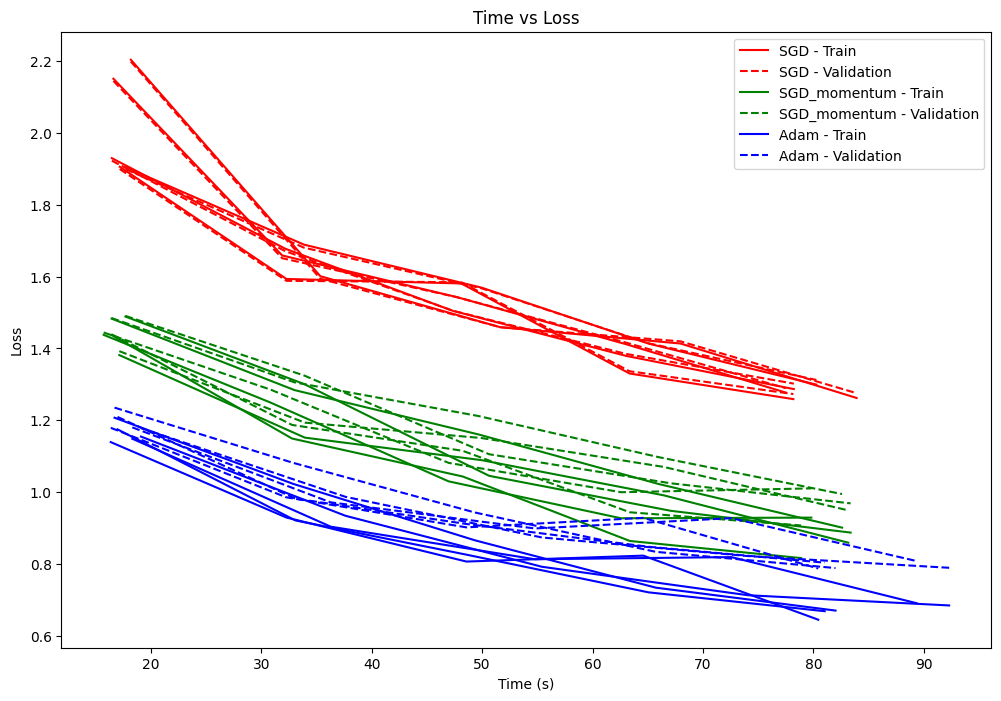

In [17]:
#### Time vs Loss Grafiği (TÜMÜ)

plt.figure(figsize=(12, 8))

for opt_name in optimizer_configs.keys():
    for idx, (history, times) in enumerate(zip(history_records[opt_name], time_records[opt_name])):
        cumulative_times = np.cumsum(times)
        # Eğitim kaybı (Train Loss)
        plt.plot(cumulative_times, history['loss'], linestyle='-', color=colors[opt_name],
                 label=f"{opt_name} - Train" if idx == 0 else "")
        # Doğrulama kaybı (Validation Loss)
        plt.plot(cumulative_times, history['val_loss'], linestyle='--', color=colors[opt_name],
                 label=f"{opt_name} - Validation" if idx == 0 else "")

plt.title('Time vs Loss')
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.legend()
plt.show()
